# MNIST CNN 분류 모델 (복구 + 확장 버전)

이 노트북은 손상된 원본을 기반으로 재구성되었으며,
다음 기능을 포함합니다:

- CNN 모델 정의
- MNIST 데이터 로딩
- 모델 학습(Training)
- 검증(Validation)
- Confusion Matrix 시각화
- 샘플 예측 시각화


In [1]:
!nvidia-smi

Wed Nov 19 13:10:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import font_manager, rcParams
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def _configure_korean_font():
    candidates = [
        "Malgun Gothic", "맑은 고딕",
        "AppleGothic", "NanumGothic",
        "Noto Sans CJK KR", "Noto Sans KR", "Noto Sans CJK",
        "NanumBarunGothic", "Gulim", "Dotum", "Batang",
    ]
    available = {f.name for f in font_manager.fontManager.ttflist}
    for name in candidates:
        if name in available:
            rcParams["font.family"] = [name]
            rcParams["axes.unicode_minus"] = False
            return name
    rcParams["axes.unicode_minus"] = False
    return None

_configure_korean_font()

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)


In [3]:
# MNIST 데이터셋 로딩 및 전처리
# transforms.Compose: 여러 이미지 변환 단계를 하나로 묶어줍니다.
transform = transforms.Compose([
    # transforms.ToTensor(): PIL 이미지나 numpy 배열을 PyTorch 텐서로 변환합니다. (0-255 -> 0.0-1.0)
    transforms.ToTensor(),
    # transforms.Normalize: 텐서 이미지를 정규화합니다. (mean, std) 튜플을 인자로 받습니다.
    # MNIST 데이터셋의 평균(0.1307)과 표준편차(0.3081)를 사용하여 정규화를 수행합니다.
    transforms.Normalize((0.1307,), (0.3081,))
])

# datasets.MNIST: torchvision에서 제공하는 MNIST 데이터셋 클래스입니다.
# root: 데이터가 저장될 경로입니다.
# train=True: 학습용 데이터셋을 로드합니다.
# download=True: 데이터가 없을 경우 자동으로 다운로드합니다.
# transform: 위에서 정의한 전처리 단계를 적용합니다.
train_set = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_set  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# DataLoader: 데이터셋을 미니배치(mini-batch) 형태로 만들어주는 유틸리티입니다.
# batch_size: 한 번에 모델에 입력할 데이터의 개수입니다.
# shuffle=True: 학습 데이터를 매 에포크마다 섞어서 모델이 데이터 순서에 과적합되는 것을 방지합니다.
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)

# 학습 및 테스트 데이터셋의 크기를 확인합니다.
len(train_set), len(test_set)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 515kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.94MB/s]


(60000, 10000)

In [4]:
# CNN(Convolutional Neural Network) 모델을 정의합니다.
class CNN(nn.Module):
    # 모델의 레이어들을 초기화합니다.
    def __init__(self):
        super().__init__()
        # nn.Conv2d: 2D 컨볼루션 레이어. (입력 채널, 출력 채널, 커널 크기, 패딩)
        # 입력 채널 1 (흑백 이미지), 출력 채널 32, 커널 3x3, 패딩 1
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        # 입력 채널 32, 출력 채널 64, 커널 3x3, 패딩 1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # nn.MaxPool2d: 2D 맥스 풀링 레이어. 특성 맵의 크기를 줄여 계산량을 감소시키고, 주요 특성을 추출합니다.
        self.pool = nn.MaxPool2d(2)
        # nn.Linear: 완전 연결 레이어(Fully Connected Layer). (입력 뉴런 수, 출력 뉴런 수)
        # 64 * 14 * 14는 풀링을 거친 후의 특성 맵 크기입니다.
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        # 최종 출력은 10개(0-9 숫자 분류)입니다.
        self.fc2 = nn.Linear(128, 10)

    # 모델의 순전파(forward pass) 로직을 정의합니다.
    def forward(self, x):
        # 첫 번째 컨볼루션 -> ReLU 활성화 함수
        x = F.relu(self.conv1(x))
        # 두 번째 컨볼루션 -> ReLU 활성화 함수 -> 맥스 풀링
        x = self.pool(F.relu(self.conv2(x)))
        # view: 텐서의 모양을 변경합니다. 2D 이미지를 1D 벡터로 펼칩니다.
        x = x.view(x.size(0), -1)
        # 첫 번째 완전 연결 레이어 -> ReLU 활성화 함수
        x = F.relu(self.fc1(x))
        # 최종 출력 레이어
        x = self.fc2(x)
        return x

# device: 학습에 사용할 장치를 설정합니다. GPU가 사용 가능하면 'cuda', 아니면 'cpu'를 사용합니다.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model: 정의한 CNN 클래스의 인스턴스를 생성하고, 지정된 장치로 모델을 이동합니다.
model = CNN().to(device)

# criterion: 손실 함수(loss function)를 정의합니다. 다중 클래스 분류 문제에 주로 사용되는 교차 엔트로피 손실을 사용합니다.
criterion = nn.CrossEntropyLoss()
# optimizer: 최적화 알고리즘을 정의합니다. Adam 옵티마이저를 사용하며, 학습률(lr)은 0.001로 설정합니다.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 설정된 장치를 확인합니다.
device

device(type='cuda')

In [5]:
# 모델 학습(Training) 및 검증(Validation) 루프
epochs = 20

# 각 에포크별 학습 및 검증 손실/정확도를 저장할 리스트를 초기화합니다.
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

# 정의된 에포크 수만큼 학습을 반복합니다.
for epoch in range(epochs):
    # --- 학습 단계 ---
    model.train() # 모델을 학습 모드로 설정합니다. (드롭아웃, 배치 정규화 등에 영향을 줌)
    total_loss = 0
    correct = 0
    total = 0

    # train_loader에서 미니배치 단위로 데이터를 불러와 학습합니다.
    for images, labels in train_loader:
        # 데이터를 지정된 장치(GPU 또는 CPU)로 이동합니다.
        images, labels = images.to(device), labels.to(device)

        # 1. 순전파(Forward Pass): 모델에 입력을 통과시켜 예측값을 얻습니다.
        outputs = model(images)
        # 2. 손실 계산: 예측값과 실제 정답 간의 손실을 계산합니다.
        loss = criterion(outputs, labels)

        # 3. 역전파(Backpropagation) 및 최적화
        optimizer.zero_grad() # 이전 배치의 기울기(gradient)를 초기화합니다.
        loss.backward()       # 손실에 대한 기울기를 계산합니다.
        optimizer.step()      # 계산된 기울기를 바탕으로 모델의 가중치를 업데이트합니다.

        # 손실과 정확도 계산을 위해 값을 누적합니다.
        total_loss += loss.item()
        _, preds = torch.max(outputs, 1) # 가장 높은 확률을 가진 클래스를 예측값으로 선택합니다.
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # 현재 에포크의 평균 학습 손실과 정확도를 계산하여 저장합니다.
    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # --- 검증 단계 ---
    model.eval() # 모델을 평가 모드로 설정합니다.
    val_loss = 0
    val_correct = 0
    val_total = 0
    # torch.no_grad(): 기울기 계산을 비활성화하여 메모리 사용량을 줄이고 계산 속도를 높입니다.
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # 현재 에포크의 평균 검증 손실과 정확도를 계산하여 저장합니다.
    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    # 에포크별 학습 및 검증 결과를 출력합니다.
    print(
        f"Epoch [{epoch+1}/{epochs}] "
        f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f} "
        f"| Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}"
    )


Epoch [1/20] Train Loss: 0.1231 | Train Acc: 0.9620 | Val Loss: 0.0487 | Val Acc: 0.9844
Epoch [2/20] Train Loss: 0.0378 | Train Acc: 0.9880 | Val Loss: 0.0372 | Val Acc: 0.9879
Epoch [3/20] Train Loss: 0.0215 | Train Acc: 0.9933 | Val Loss: 0.0353 | Val Acc: 0.9888
Epoch [4/20] Train Loss: 0.0159 | Train Acc: 0.9946 | Val Loss: 0.0469 | Val Acc: 0.9867
Epoch [5/20] Train Loss: 0.0113 | Train Acc: 0.9960 | Val Loss: 0.0376 | Val Acc: 0.9895
Epoch [6/20] Train Loss: 0.0086 | Train Acc: 0.9970 | Val Loss: 0.0435 | Val Acc: 0.9878
Epoch [7/20] Train Loss: 0.0082 | Train Acc: 0.9972 | Val Loss: 0.0444 | Val Acc: 0.9890
Epoch [8/20] Train Loss: 0.0053 | Train Acc: 0.9981 | Val Loss: 0.0522 | Val Acc: 0.9872
Epoch [9/20] Train Loss: 0.0063 | Train Acc: 0.9978 | Val Loss: 0.0507 | Val Acc: 0.9892
Epoch [10/20] Train Loss: 0.0047 | Train Acc: 0.9983 | Val Loss: 0.0548 | Val Acc: 0.9888
Epoch [11/20] Train Loss: 0.0035 | Train Acc: 0.9990 | Val Loss: 0.0614 | Val Acc: 0.9883
Epoch [12/20] Train

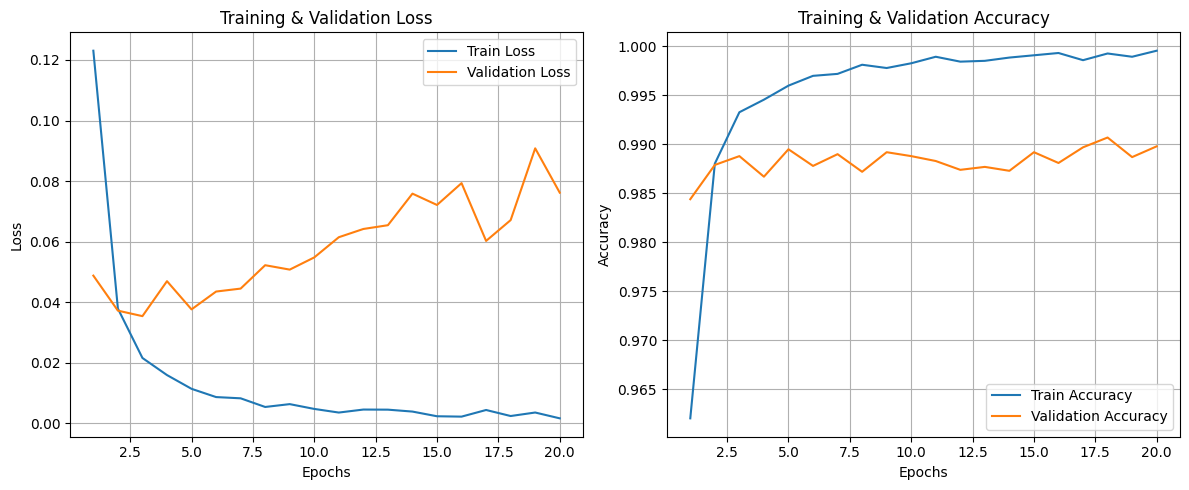

In [6]:
# 학습 과정의 성능(손실 및 정확도)을 시각화합니다.
plt.figure(figsize=(12, 5)) # 그래프의 전체 크기를 설정합니다.

# 첫 번째 서브플롯: 손실(Loss) 그래프
plt.subplot(1, 2, 1) # 1행 2열의 그리드에서 첫 번째 위치에 서브플롯을 생성합니다.
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss') # x축: 에포크, y축: 학습 손실
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss') # x축: 에포크, y축: 검증 손실
plt.xlabel('Epochs') # x축 레이블 설정
plt.ylabel('Loss') # y축 레이블 설정
plt.title('Training & Validation Loss') # 그래프 제목 설정
plt.legend() # 범례 표시
plt.grid(True) # 그리드 표시

# 두 번째 서브플롯: 정확도(Accuracy) 그래프
plt.subplot(1, 2, 2) # 1행 2열의 그리드에서 두 번째 위치에 서브플롯을 생성합니다.
plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy') # x축: 에포크, y축: 학습 정확도
plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy') # x축: 에포크, y축: 검증 정확도
plt.xlabel('Epochs') # x축 레이블 설정
plt.ylabel('Accuracy') # y축 레이블 설정
plt.title('Training & Validation Accuracy') # 그래프 제목 설정
plt.legend() # 범례 표시
plt.grid(True) # 그리드 표시

plt.tight_layout() # 서브플롯 간의 간격을 자동으로 조절합니다.
plt.show() # 그래프를 화면에 출력합니다.


In [7]:
# 최종 모델 성능 평가
model.eval() # 모델을 평가 모드로 설정합니다.
correct = 0
total = 0
# 혼동 행렬(Confusion Matrix) 및 기타 분석을 위해 예측값과 실제값을 저장할 리스트입니다.
predictions = []
targets = []

# 기울기 계산을 비활성화합니다.
with torch.no_grad():
    # 테스트 데이터로더에서 데이터를 배치 단위로 불러옵니다.
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images) # 모델 예측
        _, preds = torch.max(outputs, 1) # 가장 높은 확률의 클래스를 예측값으로 선택

        # 예측값과 실제값을 CPU로 이동시켜 numpy 배열로 변환한 후 리스트에 추가합니다.
        predictions.extend(preds.cpu().numpy())
        targets.extend(labels.cpu().numpy())

        # 전체 정확도 계산을 위해 맞춘 개수를 누적합니다.
        correct += (preds == labels).sum().item()
        total += labels.size(0)

# 최종 정확도를 계산하고 출력합니다.
print("Accuracy:", correct / total)


Accuracy: 0.9898


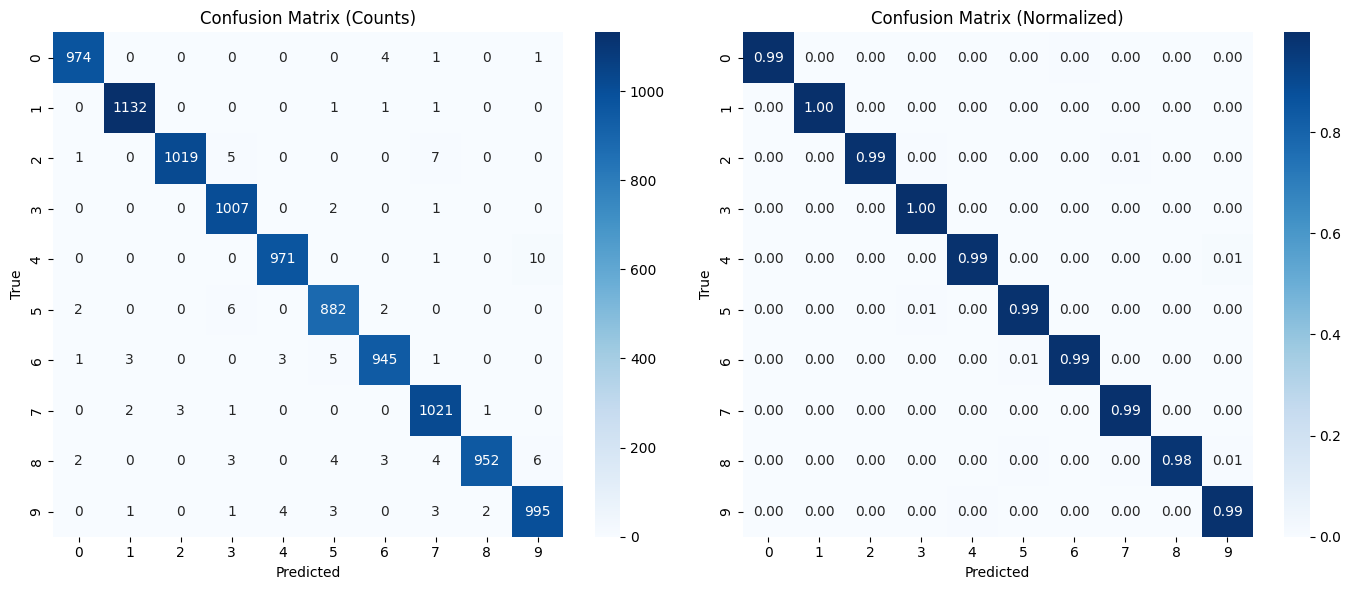

In [8]:
# 혼동 행렬(Confusion Matrix) 시각화
# 혼동 행렬은 모델의 예측이 각 클래스별로 얼마나 잘 수행되었는지 보여주는 표입니다.
# (행: 실제 클래스, 열: 예측 클래스)

# 평가 단계에서 predictions와 targets 리스트가 채워졌는지 확인합니다.
if not predictions or not targets or len(predictions) != len(targets):
    raise RuntimeError("Run the evaluation cell first to populate targets/predictions.")

labels = list(range(10)) # 클래스 레이블 (0-9)
# sklearn.metrics.confusion_matrix를 사용하여 혼동 행렬을 계산합니다.
# cm_counts: 각 클래스별 예측 개수
cm_counts = confusion_matrix(targets, predictions, labels=labels)
# cm_normalized: 각 실제 클래스 내에서 예측 비율 (정규화)
cm_normalized = confusion_matrix(targets, predictions, labels=labels, normalize="true")

fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # 2개의 서브플롯을 생성합니다.

# 첫 번째 서브플롯: 예측 개수 기준 혼동 행렬
sns.heatmap(
    cm_counts,
    annot=True,  # 각 셀에 값을 표시합니다.
    fmt="d",     # 정수 형태로 값을 표시합니다.
    cmap="Blues",# 색상 맵을 설정합니다.
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[0],  # 첫 번째 서브플롯에 그립니다.
)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# 두 번째 서브플롯: 정규화된 혼동 행렬
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".2f",   # 소수점 둘째 자리까지 표시합니다.
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
    ax=axes[1],  # 두 번째 서브플롯에 그립니다.
)
axes[1].set_title("Confusion Matrix (Normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


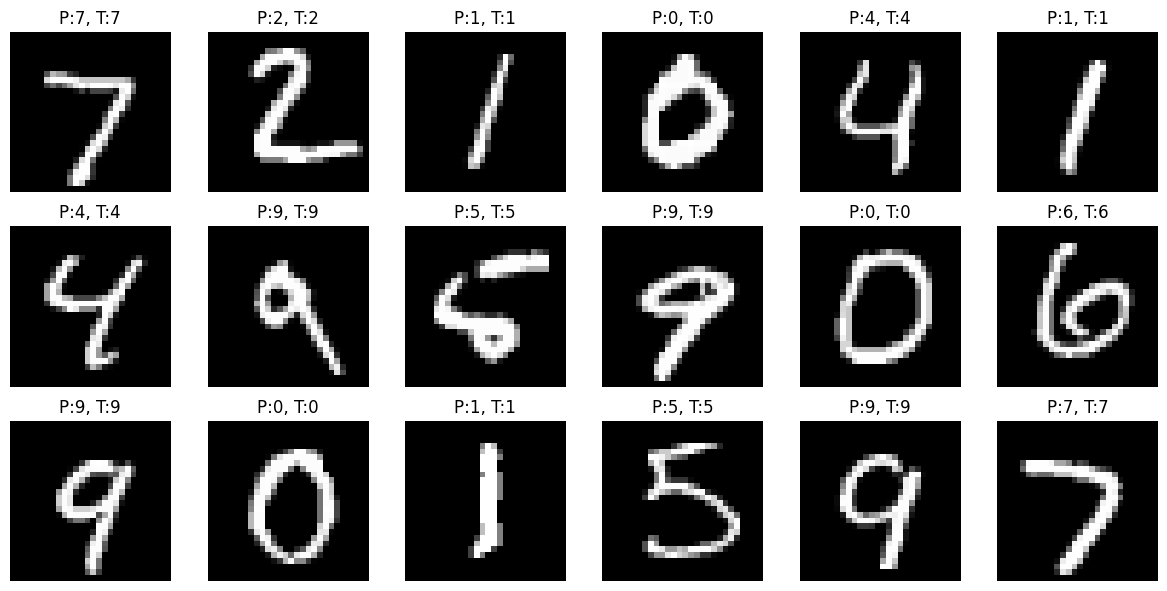

In [9]:
# 테스트 데이터셋의 일부 샘플에 대한 예측 결과를 시각적으로 확인합니다.
def show_samples():
    model.eval() # 모델을 평가 모드로 설정합니다.
    # 테스트 로더에서 데이터 한 배치를 가져옵니다.
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    # 모델 예측
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    # 3x6 그리드의 서브플롯을 생성합니다.
    fig, axes = plt.subplots(3, 6, figsize=(12,6))
    idx = 0

    # 18개의 샘플 이미지를 반복하며 출력합니다.
    for i in range(3):
        for j in range(6):
            # squeeze(): 텐서에서 크기가 1인 차원을 제거합니다. (1, 28, 28) -> (28, 28)
            axes[i][j].imshow(images[idx].cpu().squeeze(), cmap="gray")
            # 각 이미지의 제목에 예측값(P)과 실제값(T)을 표시합니다.
            axes[i][j].set_title(f"P:{preds[idx].item()}, T:{labels[idx].item()}")
            axes[i][j].axis("off") # 축 정보를 숨깁니다.
            idx += 1

    plt.tight_layout()
    plt.show()

# 함수를 호출하여 샘플 예측을 확인합니다.
show_samples()
